<Figure size 432x288 with 0 Axes>

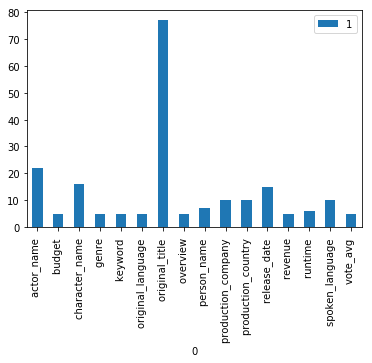

What are the most relevant actors in movie_key? 
What actors entered movie_key? 
Which characters were there on movie_key? 
What characters can be seen in movie_key? 
What are the languages spoken in movie_key? 
Who was the director of movie_key? 
Who starred in movie_key? 
What actor played the part of Jake Sully in movie_key? 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random
import nltk
from nltk import FreqDist, pos_tag, ne_chunk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, PunktSentenceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.classify import accuracy
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

df = pd.read_table('QuestoesConhecidas.txt', header=None, encoding = 'utf-8')
nq = pd.read_table('NovasQuestoes.txt', header=None, encoding = 'utf-8')
nqr = pd.read_table('NovasQuestoesResultados.txt', header=None, encoding = 'utf-8')
char_list = pd.read_table('recursos/list_characters.txt', sep="\n", header=None, encoding = 'utf-8')
company_list = pd.read_table('recursos/list_companies.txt', header=None, encoding = 'utf-8')
genre_list = pd.read_table('recursos/list_genres.txt', header=None, encoding = 'utf-8')
job_list = pd.read_table('recursos/list_jobs.txt', header=None, encoding = 'utf-8')
keyword_list = pd.read_table('recursos/list_keywords.txt', header=None, encoding = 'utf-8')
movie_list = pd.read_table('recursos/list_movies.txt', header=None, encoding = 'utf-8')
people_list = pd.read_table('recursos/list_people.txt', sep="\n", header=None, encoding = 'utf-8')


Y = df[0]
X = df[1]
nq = nq[0]
nqr = nqr[0]

classes = []
all_words = []
key_list = [char_list, company_list, genre_list, job_list, keyword_list,
            movie_list, people_list]

for key in key_list:
    key = set(key[0])
    
key_dict = {"movie_key":movie_list , "people_key":people_list}

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
tokenizer = PunktSentenceTokenizer()

def remove_spaces(text):
    return text.strip(' ')

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    
    return text

def remove_stopwords(text):
    filtered_text = []
    for word in text:
        if word not in stop_words:
            filtered_text.append(word)
    return filtered_text

def lemmatize_words(text):
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text


def gather_all_words(text):
    for words in text:
        words = word_tokenize(words)
        for word in words:
            all_words.append(word)
    return all_words

def find_features(text):
    features = {}
    for word in word_features:
        features[word] = (word in text)
    return features

def find_feature_set(data):
    feature_set = []
    for text, clss in data:
        feature_set.append((find_features(text),clss))
    return feature_set

def replace_keyword(text):
    for name, key in key_dict.items():
        for val in key[0]:
            if "*" in val:
                val = val.replace('*','\*')
            if re.findall('\\b' + val + '\\b', text):
                text = text.replace(val, name)  
    print(text)
    return text

for _, item in Y.iteritems():
    if item not in classes:
        classes.append(item)
                
classes = list(map(remove_spaces, classes))
#print(classes)

plt.figure()
df.groupby(0).count().plot.bar(ylim=0)
plt.show()


X = X.apply(lambda text : replace_keyword(text))
X = X.apply(lambda text : clean_text(text))
#print(X.head())
X = X.apply(lambda text : word_tokenize(text))
#print(X.head())
X = X.apply(lambda text : remove_stopwords(text))
#print(X.head())
X = X.apply(lambda text : lemmatize_words(text))
#print(X.head())

gather_all_words(X)
        
all_words_fd = FreqDist(all_words)
        
#print(all_words)
#print(all_words_fd)

#print(X)

word_features = list(all_words_fd.keys())
#print(word_features)

#features = find_features(X[0])
#print(features)

quest = list(zip(X, Y))

np.random.seed = 1       #seed para repetição
np.random.shuffle(quest) #shuffling para garantir que as classes não ficam agrupadas

feature_set = find_feature_set(quest)
#print(feature_set)
#print(quest)

nq = nq.apply(lambda text : replace_keyword(text))
nq = nq.apply(lambda text : clean_text(text))
#print(X.head())
nq = nq.apply(lambda text : word_tokenize(text))
#print(X.head())
nq = nq.apply(lambda text : remove_stopwords(text))
#print(X.head())
nq = nq.apply(lambda text : lemmatize_words(text))
#print(nqr)

nq_feature_set = []
for text in nq:
    nq_feature_set.append(find_features(text))
    
#print(nq_feature_set)

test = list(zip(nq, nqr))

test_feature_set = find_feature_set(test)
#print(test_feature_set)




In [8]:
names = ['K Nearest Neighbors','Decision Tree','Random Forest','Logistic Regression','SGD Classifier', 'Naive Bayes', 'SVM Linear']

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    
    SVC(kernel = 'linear')
]

models = zip(names, classifiers)

for name, classifier in models:
    nltk_classifier = SklearnClassifier(classifier)
    nltk_classifier.train(feature_set)
    class_set = nltk_classifier.classify_many(nq_feature_set)
    accuracy = nltk.classify.accuracy(nltk_classifier, test_feature_set) * 100
    print(name, "accuracy :", accuracy)
    print(class_set)
    




K Nearest Neighbors accuracy : 85.71428571428571
['actor_name ', 'character_name ', 'character_name ', 'spoken_language ', 'person_name ', 'actor_name ', 'character_name ', 'character_name ', 'spoken_language ', 'person_name ', 'overview ', 'actor_name ', 'actor_name ', 'actor_name ', 'character_name ', 'character_name ', 'spoken_language ', 'person_name ', 'person_name ', 'person_name ', 'actor_name ', 'actor_name ', 'actor_name ', 'character_name ', 'character_name ', 'spoken_language ', 'person_name ', 'person_name ', 'person_name ', 'actor_name ', 'character_name ', 'character_name ', 'spoken_language ', 'person_name ', 'actor_name ', 'character_name ', 'spoken_language ', 'person_name ', 'overview ', 'actor_name ', 'actor_name ', 'character_name ']
Decision Tree accuracy : 88.09523809523809
['actor_name ', 'character_name ', 'character_name ', 'spoken_language ', 'person_name ', 'original_title ', 'character_name ', 'character_name ', 'spoken_language ', 'person_name ', 'actor_nam

In [43]:
example_text = "Hello how are you doing? Fine and you? I am good as well."

words = word_tokenize(example_text)
stop_words = set(stopwords.words("english"))

filtered_sentence = []

for w in words:
    if w not in stop_words:
        filtered_sentence.append(w)
        
print(filtered_sentence)

['Hello', '?', 'Fine', '?', 'I', 'good', 'well', '.']


In [37]:
print(lemmatizer.lemmatize("geese"))

goose


In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [35]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [8]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [10]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping chunkers\maxent_ne_chunker.zip.


True

In [12]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [ ]:
quest_train, quest_test, class_train, class_test = train_test_split(questoes, classes, test_size=0.3, random_state=0)

print(classes.value_counts())

encoder = LabelEncoder()
Y = encoder.fit_transform(classes)


In [55]:
cities = ['London', 'age of ultron', 'Birmingham']
where = "Where are age of ultron you trying to find"
for city in cities:
    if city in where:
        where = where.replace(city, "movie")
        print(where)
        break
else:
    print("I'm not to sure")

Where are movie you trying to find


In [18]:
lemmatizer.lemmatize("boys")

'boy'

[{'W': False, 'h': False, 'a': True, 't': True, 'r': True, 'e': True, 'l': True, 'v': True, 'n': True, 'c': True, 'o': True, 's': False, 'm': False, 'i': False, '_': False, 'k': False, 'y': True, '?': False, 'd': True, 'f': False, 'g': False, 'u': False, 'p': False, "'": False, 'E': False, 'A': False, 'T': False, 'L': False, ':': False, 'F': False, 'w': False, '.': False, 'S': False, 'b': True, 'z': False, 'I': False, 'x': False, ',': False, '0': False, 'K': False}, {'W': False, 'h': True, 'a': True, 't': True, 'r': True, 'e': True, 'l': True, 'v': False, 'n': True, 'c': True, 'o': True, 's': False, 'm': False, 'i': True, '_': False, 'k': False, 'y': False, '?': False, 'd': True, 'f': True, 'g': True, 'u': False, 'p': False, "'": False, 'E': False, 'A': False, 'T': False, 'L': False, ':': False, 'F': False, 'w': False, '.': False, 'S': False, 'b': False, 'z': False, 'I': False, 'x': False, ',': False, '0': False, 'K': False}, {'W': False, 'h': True, 'a': True, 't': True, 'r': True, 'e'

In [67]:
movies_list = movies[0]
mov_list = []

for mov in movies_list:
    mov_list.append(mov)
    
print(replace_keyword("I watched Avengers: Age of Ultron and I loved it.", mov_list))



I watched movie and I loved it.


In [87]:
key_dict['character'][0]

0                         Robinson
1                          Abraxas
2                            Adams
3                        Ahluwalia
4                         Anderson
5                        Armstrong
6                           Arthur
7                          Babitch
8                            Baker
9                             Band
10                            Barr
11                      Barrington
12                          Barrow
13                          Baskin
14                        Bjornsen
15                           Black
16                       Blutarski
17                            Boca
18                            Cage
19                         Cameron
20                           Capel
21                          Carter
22                        Charming
23                        Charmont
24                   Chevotarevich
25                          Chopra
26                           Clark
27                            Cobb
28                  

In [31]:
val = "Robinson"
text = "My name is Robinson James"
print(re.search(r'\b{}\b'.format(val),text))

<re.Match object; span=(11, 19), match='Robinson'>


In [34]:
(r'\b{}\b'.format("What the #$*! Do We (K).now!?"))

'\\bWhat the #$*! Do We (K).now!?\\b'

In [39]:
re.search(r'\b{}\b'.format(' #$*!'),"What the #$*! Do We (K).now!?" )

error: nothing to repeat at position 5

# Versão para entregar

In [5]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk import FreqDist, pos_tag, ne_chunk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, PunktSentenceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.classify import accuracy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

df = pd.read_table("QuestoesConhecidas.txt", header=None, encoding = 'utf-8')
nq = pd.read_table("NovasQuestoes.txt", header=None, encoding = 'utf-8')
char_list = pd.read_table('recursos/list_characters.txt', sep="\n", header=None, encoding = 'utf-8')
company_list = pd.read_table('recursos/list_companies.txt', header=None, encoding = 'utf-8')
genre_list = pd.read_table('recursos/list_genres.txt', header=None, encoding = 'utf-8')
job_list = pd.read_table('recursos/list_jobs.txt', header=None, encoding = 'utf-8')
keyword_list = pd.read_table('recursos/list_keywords.txt', header=None, encoding = 'utf-8')
movie_list = pd.read_table('recursos/list_movies.txt', header=None, encoding = 'utf-8')
people_list = pd.read_table('recursos/list_people.txt', sep="\n", header=None, encoding = 'utf-8')


Y = df[0]
X = df[1]
nq = nq[0]

all_words = []

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
tokenizer = PunktSentenceTokenizer()

def remove_spaces(text):
    return text.strip(' ')

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    
    return text

def remove_stopwords(text):
    filtered_text = []
    for word in text:
        if word not in stop_words:
            filtered_text.append(word)
    return filtered_text

def lemmatize_words(text):
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text


def gather_all_words(text):
    for words in text:
        words = word_tokenize(words)
        for word in words:
            all_words.append(word)
    return all_words

def find_features(text):
    features = {}
    for word in word_features:
        features[word] = (word in text)
    return features

def find_feature_set(data):
    feature_set = []
    for text, clss in data:
        feature_set.append((find_features(text),clss))
    return feature_set

X = X.apply(lambda text : clean_text(text))
X = X.apply(lambda text : word_tokenize(text))
X = X.apply(lambda text : remove_stopwords(text))
X = X.apply(lambda text : lemmatize_words(text))

gather_all_words(X)
        
all_words_fd = FreqDist(all_words)
word_features = list(all_words_fd.keys())
quest = list(zip(X, Y))

np.random.seed = 1       #seed para repetição
np.random.shuffle(quest) #shuffling para garantir que as classes não ficam agrupadas

feature_set = find_feature_set(quest)

nq = nq.apply(lambda text : clean_text(text))
nq = nq.apply(lambda text : word_tokenize(text))
nq = nq.apply(lambda text : remove_stopwords(text))
nq = nq.apply(lambda text : lemmatize_words(text))

nq_feature_set = []
for text in nq:
    nq_feature_set.append(find_features(text))

nltk_classifier = SklearnClassifier(LogisticRegression())
nltk_classifier.train(feature_set)
class_set = nltk_classifier.classify_many(nq_feature_set)

    

In [6]:
print(class_set)

['actor_name ', 'character_name ', 'character_name ', 'spoken_language ', 'person_name ', 'actor_name ', 'character_name ', 'character_name ', 'spoken_language ', 'person_name ', 'actor_name ', 'actor_name ', 'actor_name ', 'actor_name ', 'character_name ', 'character_name ', 'spoken_language ', 'person_name ', 'person_name ', 'person_name ', 'actor_name ', 'actor_name ', 'actor_name ', 'character_name ', 'character_name ', 'spoken_language ', 'person_name ', 'person_name ', 'person_name ', 'actor_name ', 'character_name ', 'character_name ', 'spoken_language ', 'person_name ', 'actor_name ', 'character_name ', 'spoken_language ', 'person_name ', 'original_title ', 'actor_name ', 'actor_name ', 'character_name ']
